# Vorhersagen mit trainiertem CNN Modell und Auswertung

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib.pylab as plt
import numpy as np

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn
print(sklearn.__version__)

assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

0.19.0


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

assert StrictVersion(tf.__version__) >= StrictVersion('1.2.1')

1.2.1


In [7]:
import keras
print(keras.__version__)

assert StrictVersion(keras.__version__) >= StrictVersion('2.0.6')

Using TensorFlow backend.


2.0.8


In [8]:
# We need keras 2.0.6 or later as this is the version we created the model with
# !pip install keras --upgrade

## Laden realistischer Daten

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/real-world.zip
from zipfile import ZipFile
zip = ZipFile(r'real-world.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1203k  100 1203k    0     0  3579k      0 --:--:-- --:--:-- --:--:-- 4039k


In [10]:
!ls -l real-world

total 0
drwxrwxrwx 0 root root 512 Sep 26 16:17 0
drwxrwxrwx 0 root root 512 Sep 26 16:17 1
drwxrwxrwx 0 root root 512 Sep 26 16:17 2
drwxrwxrwx 0 root root 512 Sep 26 16:17 3
drwxrwxrwx 0 root root 512 Sep 26 16:17 4
drwxrwxrwx 0 root root 512 Sep 26 16:17 5


In [11]:
import os
import skimage.data
import skimage.transform

def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    all_file_names = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
            all_file_names.append(f)
    # Resize images
    images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]
    return images64, labels, all_file_names

In [12]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "real-world")

images, labels, file_names = load_data(data_dir)

In [13]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    plt.figure(figsize=(15, 15))
    i = 0
    for label in labels:
        # Pick the first image for each label.
        image = images[i]
        plt.subplot(4, 4, i + 1)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("{0}".format(label))
        i += 1
        plt.imshow(image)
    plt.show()

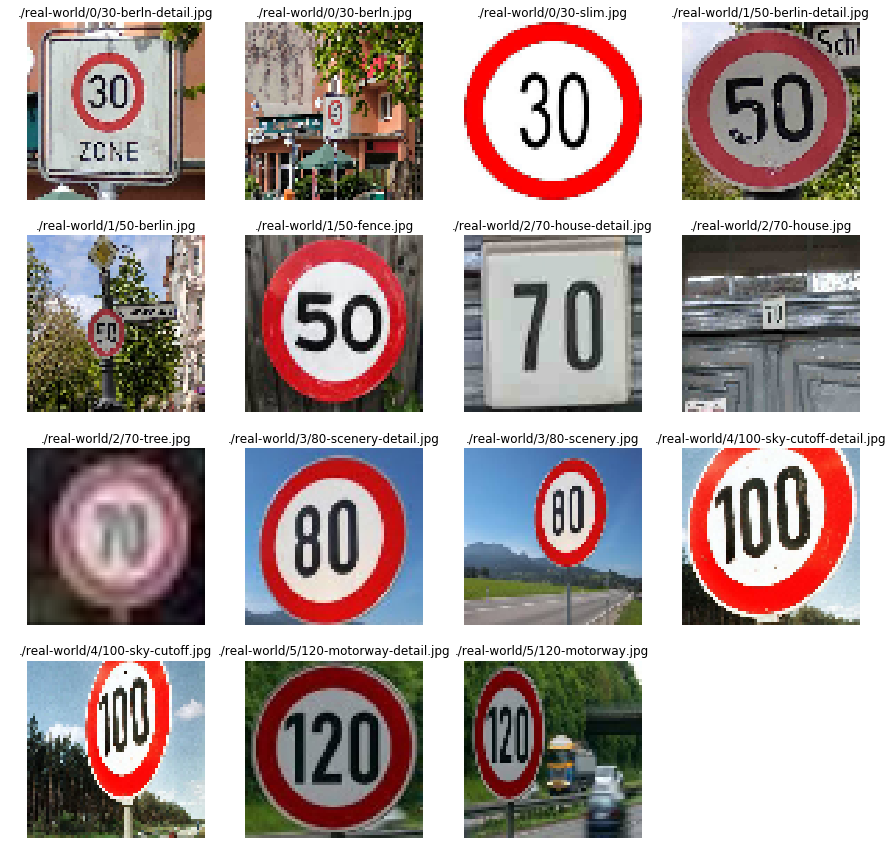

In [14]:
display_images_and_labels(images, file_names)

## Modell laden

In [15]:
!curl -O https://transfer.sh/M5SOs/conv-vgg.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54.8M  100 54.8M    0     0  1841k      0  0:00:30  0:00:30 --:--:-- 6681k:06:10 2535k


In [16]:
from keras.models import load_model
model = load_model('conv-vgg.hdf5')

In [17]:
!ls -lh

total 30G
drwxrwxrwx 0 root root  512 Sep 25 18:10 augmented-signs
-rwxrwxrwx 1 root root 136K Sep 25 18:12 cnn-augmentation.ipynb
-rwxrwxrwx 1 root root 1.6M Sep 25 14:57 cnn-comparing-all-models.ipynb
-rwxrwxrwx 1 root root 380K Sep 25 15:46 cnn-intro.ipynb
-rwxrwxrwx 1 root root 1.3M Sep 25 14:57 cnn-prediction.ipynb
-rwxrwxrwx 1 root root 198K Sep 25 18:14 cnn-train-augmented.ipynb
-rwxrwxrwx 1 root root  55M Sep 26 16:18 conv-vgg.hdf5
drwxrwxrwx 0 root root  512 Sep 25 18:08 generated
drwxrwxrwx 0 root root  512 Sep 25 18:06 __MACOSX
-rwxrwxrwx 1 root root 113K Sep 25 17:14 nn-intro.ipynb
-rwxrwxrwx 1 root root   63 Sep 25 14:57 README.html
drwxrwxrwx 0 root root  512 Sep 26 16:17 real-world
-rwxrwxrwx 1 root root 1.2M Sep 26 16:17 real-world.zip
-rwxrwxrwx 1 root root   36 Aug  3 21:15 sample_iris.json
drwxrwxrwx 0 root root  512 Sep 25 18:06 speed-limit-signs
-rwxrwxrwx 1 root root 6.9K Sep 25 18:11 workshop.ipynb


In [18]:
BATCH_SIZE = 500

y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
loss, accuracy

15/15 [==============================] - 1s


(5.5410223007202148, 0.60000002384185791)

In [19]:
import skimage.transform
def predict_single(image):
    # normalize
    X_sample = np.array([image])
    prediction = model.predict(X_sample)
    predicted_category = np.argmax(prediction, axis=1)
    return predicted_category, prediction

In [20]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(6, 3,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

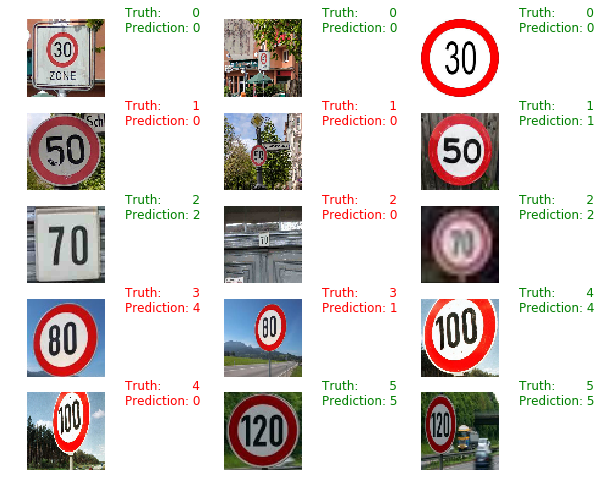

In [21]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
ground_truth = np.array(labels)
display_prediction(images, ground_truth, predicted_categories)

# Bewertung: 9 von 15 richtig, 60% Accracy

## Gar nicht mal so schlecht, besonders weil wir Translations Invariance nie trainiert haben

### Aber
* no translation invariance, signes have to be at center
* not robust against background
* false positives (70 is address sign, not traffic sign)
* not robust against unclear signes (50 looks like 30)
* not robust against distortions (100, 80)

### Next steps might be to
* artifically expand training set by applying transformations that match missing robustness
* introduce category 'no speed limit sign'
* translation invariance added in training material
* try other architectures

## Wir gucken mal unter die Haube
Bisher haben wir das Modell als Blackbox angesehen, wir haben gar keine Ahnung, was da eigentlich erkannt wird

### Warum wird das mit der 80 nichts?

#### Nach der ersten Conv Schicht
![80 Conv1](https://github.com/DJCordhose/ai/raw/master/docs/img/conv/80-conv1.png)

#### Nach einer mittleren Conv Schicht
![80 Conv3](https://github.com/DJCordhose/ai/raw/master/docs/img/conv/80-conv3.png)

#### Nach der letzten Conv Schicht
![80 Conv5](https://github.com/DJCordhose/ai/raw/master/docs/img/conv/80-conv5.png)

In [28]:
!rm -r tmp
!mkdir tmp

In [ ]:
# Only works locally

# https://github.com/keplr-io/quiver

# create a tmp dir in the local directory this notebook runs in, otherwise quiver will fail (and won't tell you why)
# !mkdir tmp

# change image_class to feed in different classes
image_class = '3'

# https://github.com/keplr-io/quiver
from quiver_engine import server
server.launch(model, input_folder=data_dir+'/'+image_class, port=7000)

# open at http://localhost:7000/
# interrupt kernel to return control to notebook

Starting webserver from: /home/olli/anaconda3/lib/python3.6/site-packages/quiver_engine


::1 - - [2017-09-26 16:29:56] "GET /model HTTP/1.1" 200 13996 0.010899
::1 - - [2017-09-26 16:29:56] "GET /inputs HTTP/1.1" 200 208 0.002569
[2017-09-26 16:30:03,196] ERROR in app: Exception on /predict/50-berlin.jpg [GET]
Traceback (most recent call last):
  File "/home/olli/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/olli/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/olli/anaconda3/lib/python3.6/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/home/olli/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/olli/anaconda3/lib/python3.6/site-packages/flask/_compat.py", line 33, in reraise
    raise value
  File "/home/oll

::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_67_50-berlin.jpg.png HTTP/1.1" 200 475 0.011436
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_68_50-berlin.jpg.png HTTP/1.1" 200 708 0.009028
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_55_50-berlin.jpg.png HTTP/1.1" 200 508 0.008458
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_56_50-berlin.jpg.png HTTP/1.1" 200 575 0.005262
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_61_50-berlin.jpg.png HTTP/1.1" 200 539 0.008910
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_50_50-berlin.jpg.png HTTP/1.1" 200 1233 0.004033
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_69_50-berlin.jpg.png HTTP/1.1" 200 570 0.009770
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_74_50-berlin.jpg.png HTTP/1.1" 200 567 0.009659
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_70_50-berlin.jpg.png HTTP/1.1" 200 1225 0.005042
::1 - - [2017-09-26 16:30:05] "GET /temp-file/conv2d_16_71_50-

In [ ]:
# Alternative mit noch mehr Visualisierungsmöglichkeiten
# https://github.com/raghakot/keras-vis

## Nutzung mit Server Installationen

### 1. Flask basiert
* https://github.com/DJCordhose/speed-limit-signs/tree/master/server

In [ ]:
# Erfordert einen lokalen Flask Server
!curl -H "Content-Type: application/json" -X GET -d '{"url": "https://github.com/DJCordhose/speed-limit-signs/raw/master/data/real-world/1000/70-house-detail.jpg"}' http://127.0.0.1:5000

In [ ]:
!curl -H "Content-Type: application/json" -X GET -d '{"url": "https://github.com/DJCordhose/speed-limit-signs/raw/master/data/real-world/4/100-sky-cutoff-detail.jpg"}' http://127.0.0.1:5000

### 2. Google Cloud ML Service
![Google Cloud ML Service](https://github.com/DJCordhose/ai/raw/master/docs/img/applications/google_cloud_ml.png)

In [ ]:
# Example for iris, model exported as Tensorflow
# gsutil cp -R 1 gs://irisnn
# create model and version at https://console.cloud.google.com/mlengine
# in a DOS shell on local machine in this folder
# gcloud ml-engine predict --model=irisnn --json-instances=./sample_iris.json
# SCORES
# [0.9954029321670532, 0.004596732556819916, 3.3544753819114703e-07]